In [1]:
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

sessions_fpath = '../data/comscore/2017/sessions.csv'

This is a big file. Some preliminary questions:


- what are the columns?
- how many rows?
- how many machines?
- what is the time range?
- how many unique domains?

In [2]:
CHUNKSIZE = 1000000 # number of rows to read at a time

Take an initial look at the columns

In [3]:
sessions_chunk = pd.read_csv(sessions_fpath, nrows=CHUNKSIZE)
print(sessions_chunk.columns)

/Users/aberke/projects/CSL_Andorra_COVID_Public/env/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (2,10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['machine_id', 'site_session_id', 'domain_id', 'ref_domain__name',
       'pages_viewed', 'duration', 'event_date', 'event_time', 'tran_flg',
       'prod_category_id', 'prod_name', 'prod_qty', 'prod_totprice',
       'basket_tot', 'hoh_most_education', 'census_region', 'household_size',
       'hoh_oldest_age', 'household_income', 'children', 'racial_background',
       'connection_speed', 'country_of_origin', 'zip_code', 'domain_name'],
      dtype='object')


In [6]:
sessions_chunk.drop('machine_id', axis=1).head(2)

,site_session_id,domain_id,ref_domain__name,pages_viewed,duration,event_date,event_time,tran_flg,prod_category_id,prod_name,...,census_region,household_size,hoh_oldest_age,household_income,children,racial_background,connection_speed,country_of_origin,zip_code,domain_name
0,2296065101119308896,,NaN,13.0,33,20171007,22:45:57,1.0,7.009031e+09,"Bosch Premium Performance Battery Group, Size 51R",...,3,5,3,12,1,2,1,1,36832.0,NaN
1,2296065101119308896,,NaN,13.0,33,20171007,22:45:57,1.0,9.990000e+02,Additional Service Required,...,3,5,3,12,1,2,1,1,36832.0,NaN


In [11]:
# it looks like the tran_flg is 1 when this is a transaction. w/e don't care.
print(sessions_chunk.tran_flg.unique())
sessions_chunk[sessions_chunk.tran_flg != 1.0].drop('machine_id', axis=1).head(2)

[ 1. nan]


,site_session_id,domain_id,ref_domain__name,pages_viewed,duration,event_date,event_time,tran_flg,prod_category_id,prod_name,...,census_region,household_size,hoh_oldest_age,household_income,children,racial_background,connection_speed,country_of_origin,zip_code,domain_name
132,4343212900663777792,10000007656169623153,NaN,1.0,1,20170515,7:25:23,NaN,NaN,NaN,...,4,3,5,14,0,3,1,1,92630.0,moonmovie.biz
133,7476887538255155754,10000020440092761508,NaN,1.0,1,20170205,23:27:22,NaN,NaN,NaN,...,4,4,10,13,1,3,1,1,87544.0,kiaanime.ru


Count and track things while reading in the file in chunks

- total rows
- machine ids
- domains
- dates


In [94]:
# count machine_id -> # total sessions
# make a map: machine_id -> {set of dates}
# make a map: event_date -> {set of machines}
# make a map: domains --> {set of machines}

total_rows = 0
machines_sessions_count = pd.Series()
machines_dates = {}
dates_machines = {}
domains_machines = {}

sessions_chunk = None
rows = 0
i = 0
for sessions_chunk in pd.read_csv(sessions_fpath, 
                                  chunksize=CHUNKSIZE,
                                  usecols=['machine_id', 'event_date', 'domain_name'],
                                  #parse_dates=['event_date'],
                                 ):
    sessions_chunk.dropna(inplace=True)
    rows = len(sessions_chunk)
    total_rows += rows
    start_d = datetime.now()
    print('%s : chunk %s : %s rows : %s total rows' % (start_d.time(), i, rows, total_rows))
    # count total sessions per machine
    machines_sessions_count = machines_sessions_count.add(
        sessions_chunk['machine_id'].value_counts(),
        fill_value=0,
    )
    # count unique sessions dates for machines by making a set of dates per machine
    _machines_dates = sessions_chunk.groupby(['machine_id'])['event_date'].agg('unique')
    for machine_id, dates in _machines_dates.to_dict().items():
        if machine_id in machines_dates:
            machines_dates[machine_id].update(set(dates))
        else:
            machines_dates[machine_id] = set(dates)
    # count unique machines per date by making a set of machines per event date
    _dates_machines = sessions_chunk.groupby(['event_date'])['machine_id'].agg('unique')
    for date, machines in _dates_machines.to_dict().items():
        if date in dates_machines:
            dates_machines[date].update(set(machines))
        else:
            dates_machines[date] = set(machines)
    # count unique machines per domain by making a set of machines per domain
    _domains_machines = sessions_chunk.groupby(['domain_name'])['machine_id'].agg('unique')
    for domain, machines in _domains_machines.to_dict().items():
        if domain in domains_machines:
            domains_machines[domain].update(set(machines))
        else:
            domains_machines[domain] = set(machines)     
    i += 1
#     if i > 5:
#         break 
    print('time to handle chunk: %s' % (datetime.now() - start_d))

/Users/aberke/projects/CSL_Andorra_COVID_Public/env/lib/python3.7/site-packages/ipykernel_launcher.py:7: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  import sys


15:32:24.362971 : chunk 0 : 999865 rows : 999865 total rows
time to handle chunk: 0:00:08.754132
15:32:34.023855 : chunk 1 : 1000000 rows : 1999865 total rows
time to handle chunk: 0:00:06.336392
15:32:41.241136 : chunk 2 : 999999 rows : 2999864 total rows
time to handle chunk: 0:00:07.143679
15:32:49.291411 : chunk 3 : 999999 rows : 3999863 total rows
time to handle chunk: 0:00:08.621332
15:32:58.788540 : chunk 4 : 1000000 rows : 4999863 total rows
time to handle chunk: 0:00:05.361728
15:33:05.116693 : chunk 5 : 999999 rows : 5999862 total rows
time to handle chunk: 0:00:08.525129
15:33:14.553755 : chunk 6 : 1000000 rows : 6999862 total rows
time to handle chunk: 0:00:09.346377
15:33:24.776694 : chunk 7 : 1000000 rows : 7999862 total rows
time to handle chunk: 0:00:06.180690
15:33:31.798675 : chunk 8 : 1000000 rows : 8999862 total rows
time to handle chunk: 0:00:01.281904
15:33:33.924036 : chunk 9 : 1000000 rows : 9999862 total rows
time to handle chunk: 0:00:01.488952
15:33:36.284613

15:44:38.395112 : chunk 82 : 999999 rows : 82999770 total rows
time to handle chunk: 0:00:07.318684
15:44:46.671823 : chunk 83 : 999997 rows : 83999767 total rows
time to handle chunk: 0:00:08.143687
15:44:55.696243 : chunk 84 : 999999 rows : 84999766 total rows
time to handle chunk: 0:00:06.286137
15:45:02.973911 : chunk 85 : 999999 rows : 85999765 total rows
time to handle chunk: 0:00:07.369534
15:45:11.347262 : chunk 86 : 1000000 rows : 86999765 total rows
time to handle chunk: 0:00:06.204482
15:45:18.646109 : chunk 87 : 1000000 rows : 87999765 total rows
time to handle chunk: 0:00:03.955627
15:45:23.508330 : chunk 88 : 999999 rows : 88999764 total rows
time to handle chunk: 0:00:09.310048
15:45:33.760030 : chunk 89 : 999998 rows : 89999762 total rows
time to handle chunk: 0:00:08.992278
15:45:43.686798 : chunk 90 : 999998 rows : 90999760 total rows
time to handle chunk: 0:00:08.075151
15:45:52.683672 : chunk 91 : 999999 rows : 91999759 total rows
time to handle chunk: 0:00:08.81673

Look at what we got...

How many total rows of data?

What is the date range of the data?

How many unique machines?

How many unique domains?

In [118]:
print('%s total rows read in %s chunks of size %s' % (total_rows, i, CHUNKSIZE))

dates = sorted([datetime.strptime(str(d),'%Y%m%d').strftime('%Y-%m-%d') for d in dates_machines.keys()])
print('time range of data: %s to %s' % (dates[0], dates[-1]))

print('%s unique machines' % len(machines_sessions_count))

print('%s unique domains' % len(domains_machines))

143670585 total rows read in 144 chunks of size 1000000
time range of data: 2017-01-01 to 2017-12-31
93793 unique machines
4852017 unique domains


What are the most popular domains and what are the distributions of machines per domain?

In [174]:
domains_machines_count = pd.Series({d: len(ms) for d, ms in domains_machines.items()})
domains_machines_count.sort_values(ascending=False).head(20)

google.com               84677
bing.com                 77292
yahoo.com                74213
facebook.com             70462
live.com                 69352
msn.com                  68955
youtube.com              68623
amazon.com               62691
microsoft.com            61701
ebay.com                 41305
walmart.com              38877
adobe.com                37070
paypal.com               36970
apple.com                36564
pinterest.com            35860
247-inc.net              34810
wikipedia.org            34279
office.com               29594
googlesyndication.com    29473
netflix.com              28138
dtype: int64

Most domains show up just once!

In [175]:
domains_machines_count.describe()

count    4.852017e+06
mean     6.375336e+00
std      1.592021e+02
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      8.467700e+04
dtype: float64

What are the rare domains like? Are they malformed? Are they personal servers?

Domains for FLoC should be eTLD+1. This is complex to check. We just check there is at least one ".".

In [176]:
domains_machines_count

001476.com                1
004b17a0c349157de.com    15
005.tv                   11
005005.com                1
007srzt.com               1
                         ..
zzsba.com                 2
zzshavuicg                1
zzstream.li               4
zztxkj.com                1
zzxwcs.com                1
Length: 4852017, dtype: int64

In [177]:
bad_count = domains_machines_count[domains_machines_count.index.map(lambda d: "." not in d)]

In [178]:
print('bad domains:')
print('%0.1f%% = %s/%s of total domains' % (
    100*len(bad_count)/len(domains_machines_count), 
    len(bad_count),
    len(domains_machines_count)
))
print(bad_count.describe())
bad_count

bad domains:
10.2% = 496377/4852017 of total domains
count    496377.000000
mean          1.012934
std           2.749253
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max        1629.000000
dtype: float64


1350server         1
aaclcmbrfrjyd      1
aadckakhnnk        1
aafmtmqj           1
aafndpilhvnruhb    1
                  ..
zzfdlhsqseb        1
zzhecrvpuvklqig    1
zzioiqnaqbhvxt     1
zzqheumcfgmgx      1
zzshavuicg         1
Length: 496377, dtype: int64

Exclude these bad domains

In [179]:
domains_machines_count = domains_machines_count[domains_machines_count.index.map(lambda d: "." in d)]

In [180]:
domains_machines_count.describe()

count    4.355640e+06
mean     6.986445e+00
std      1.680155e+02
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      8.467700e+04
dtype: float64

Text(0.5, 1.0, 'histogram of machines per domain')

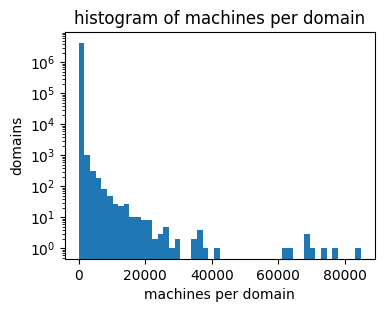

In [184]:
fig, ax = plt.subplots(1,1, figsize=(4,3), dpi=100)
domains_machines_count.plot.hist(logy=True, ax=ax, bins=50)
ax.set_xlabel('machines per domain')
ax.set_ylabel('domains')
ax.set_title('histogram of machines per domain')

How many total sessions per machine?

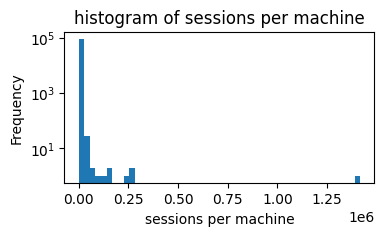

count    9.379300e+04
mean     1.531784e+03
std      5.490888e+03
min      1.000000e+00
25%      1.750000e+02
50%      6.170000e+02
75%      1.797000e+03
max      1.416960e+06
dtype: float64

excluding outliers
count    89102.000000
mean      1084.772373
std       1296.935369
min          1.000000
25%        162.000000
50%        552.000000
75%       1527.000000
max       6017.000000
dtype: float64


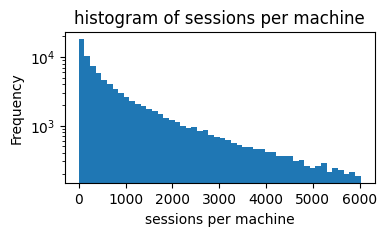

In [201]:
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=100)
machines_sessions_count.plot.hist(logy=True, ax=ax, bins=50)
ax.set_xlabel('sessions per machine')
ax.set_title('histogram of sessions per machine')
plt.show()
print(machines_sessions_count.describe())
print('\nexcluding outliers')
machines_sessions_count_95 = machines_sessions_count[machines_sessions_count < machines_sessions_count.quantile(.95)]
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=100)
machines_sessions_count_95.plot.hist(logy=True, ax=ax, bins=50)
print(machines_sessions_count_95.describe())
ax.set_xlabel('sessions per machine')
_ = ax.set_title('histogram of sessions per machine')

What is the distribution of the unique number of days of sessions per machine?

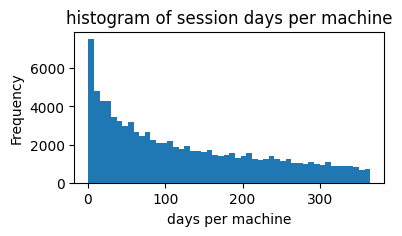

count    93793.000000
mean       125.569872
std        102.483746
min          1.000000
25%         36.000000
50%         99.000000
75%        203.000000
max        365.000000
dtype: float64


In [206]:
machines_dates_count = pd.Series({m: len(dates) for m, dates in machines_dates.items()})
fig, ax = plt.subplots(1,1, figsize=(4,2), dpi=100)
machines_dates_count.plot.hist(ax=ax, bins=50)
ax.set_xlabel('days per machine')
ax.set_title('histogram of session days per machine')
plt.show()
print(machines_dates_count.describe())

How many machines per day?

In [210]:
dates_machines_count = pd.Series({datetime.strptime(str(d), '%Y%m%d'):len(m) for d, m in dates_machines.items()})
dates_machines_count.describe()

count      365.000000
mean     32267.328767
std       3252.646984
min       9475.000000
25%      30506.000000
50%      32619.000000
75%      34904.000000
max      37307.000000
dtype: float64

Note the daily machine count is much smaller than the total number of machines. However, we are interested in weekly machine count (where machines have at least 7 domains visited) w.r.t. FLoC analysis.

In [212]:
dates_machines_count

2017-01-01    27198
2017-01-02    32635
2017-01-03    34964
2017-01-04    34760
2017-01-05    34712
              ...  
2017-12-27    29951
2017-12-28    30149
2017-12-29    29979
2017-12-30    27083
2017-12-31    25887
Length: 365, dtype: int64

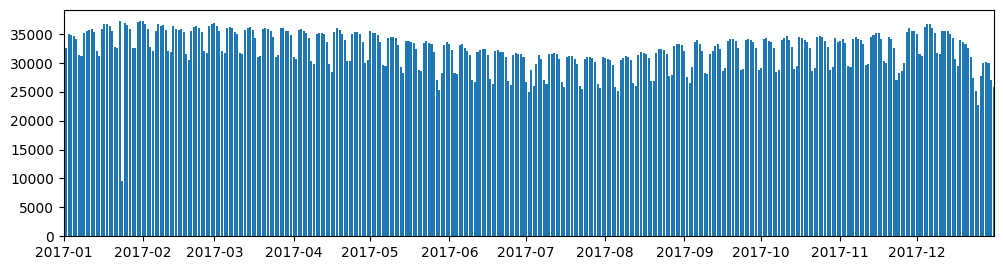

In [236]:
fig, ax = plt.subplots(1,1, figsize=(12,3), dpi=100)
ax.bar(dates_machines_count.index, dates_machines_count)
ax.set_xlim(dates_machines_count.index[0], dates_machines_count.index[-1])
plt.show()

In [265]:
dates = [datetime.strptime(str(d), '%Y%m%d') for d in unique_dates]

In the following analysis we exclude sessions from 2017-01-01 (Jan 1).

This is because...
- we need a way to divide browser histories into 7-day intervals
- we use the isocalendar function to extract calendar weeks from the session event dates
- isocalendar codes Jan 1 as week 52 instead of week 1
- excluding 1 day from 365 days give us perfect 364/52 weeks -> 7 days per calendar week

Here I'll show you...

calendar week for jan 1: 52
calendar week for jan 2: 1
calendar week for jan 3: 1


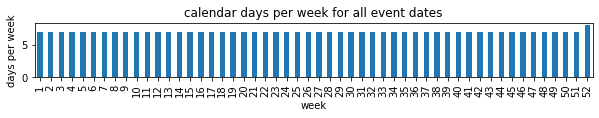

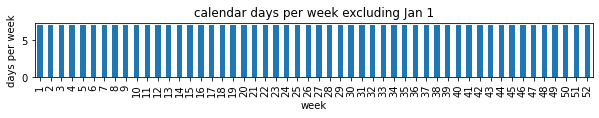

In [274]:
jan1 = datetime.strptime(str('20170101'), '%Y%m%d')
print('calendar week for jan 1: %s' % jan1.isocalendar()[1])
print('calendar week for jan 2: %s' % datetime.strptime(str('20170102'), '%Y%m%d').isocalendar()[1])
print('calendar week for jan 3: %s' % datetime.strptime(str('20170103'), '%Y%m%d').isocalendar()[1])

def plot_days_per_week(dates):
    dates_weeks = [d.isocalendar()[1] for d in dates]
    fig,ax = plt.subplots(1,1,figsize=(10,1))
    pd.Series(dates_weeks).value_counts().sort_index().plot.bar(ax=ax)
    ax.set_xlabel('week')
    ax.set_ylabel('days per week')
    return ax
    
ax = plot_days_per_week(dates)
ax.set_title('calendar days per week for all event dates')

ax = plot_days_per_week([d for d in dates if d > jan1])
_ = ax.set_title('calendar days per week excluding Jan 1')

Collect machines data for panel FLoC analysis.

Create a table:

```
week, machine_id, domains, n_domains
```

where domains is the unique set of domains visited by machine_id for given week.

To make this by processing data in chunks, we collect unique set of domains per week, machine in a dictionary and then transform the dictionary back into a dataframe.


In [405]:
# make a map: {week: {machine_id: {set of domains from the week}}}
weeks_machines_domains = {w: {machine_id: set() for machine_id in machines_dates} for w in range(1, 52+1)}

In [406]:
sessions_chunk = None
total_rows = 0
i = 0
for sessions_chunk in pd.read_csv(sessions_fpath, 
                                  chunksize=CHUNKSIZE,
                                  usecols=['machine_id', 'event_date', 'domain_name'],
                                  parse_dates=['event_date'],
                                 ):
    start_d = datetime.now()
    print('%s : chunk %s' % (start_d.time(), i))
    # drop rows with nan or malformed domains
    sessions_chunk.dropna(inplace=True)
    # drop malformed domains
    sessions_chunk = sessions_chunk[sessions_chunk.domain_name.map(lambda d: "." in d)]
    # drop rows where event date is Jan 1 2017.
    sessions_chunk = sessions_chunk[sessions_chunk.event_date > jan1]
    rows = len(sessions_chunk)
    total_rows += rows
    print('%s rows --> %s total rows' % (rows, total_rows))
    #print('2 %s : chunk %s' % (datetime.now().time(), i))
    # assign weeks
    sessions_chunk['week'] = sessions_chunk.event_date.apply(lambda d: d.isocalendar()[1])
    #print('3 %s : chunk %s' % (datetime.now().time(), i))
    # group by week, machine_id so that each row corresponds to list of unique
    # domains visited for given week for given machine
    week_machine_domains = sessions_chunk.groupby(
        ['week', 'machine_id']
    )['domain_name'].unique()
    #print('4 %s : chunk %s' % (datetime.now().time(), i))
    # iterate over weeks to update the week_machines_domains dict for each week
    for w in range(1, 52+1):
        # maps for week w, {machine_id -> [array of unique domains]}
        w_machine_domains_dict = week_machine_domains.xs(w).to_dict()
        for m, d_array in w_machine_domains_dict.items():
            weeks_machines_domains[w][m].update(set(d_array))    
    i += 1
#     if i > 1:
#         break 
    print('time to handle chunk: %s' % (datetime.now() - start_d)) 

17:44:46.293821 : chunk 0
992897 rows --> 992897 total rows
time to handle chunk: 0:01:39.992049
17:46:27.362385 : chunk 1
994667 rows --> 1987564 total rows
time to handle chunk: 0:00:28.510595
17:46:56.987386 : chunk 2
994243 rows --> 2981807 total rows
time to handle chunk: 0:00:30.412497
17:47:28.487261 : chunk 3
992891 rows --> 3974698 total rows
time to handle chunk: 0:00:33.236638
17:48:02.734282 : chunk 4
991085 rows --> 4965783 total rows
time to handle chunk: 0:00:28.308754
17:48:32.113937 : chunk 5
992174 rows --> 5957957 total rows
time to handle chunk: 0:01:46.593701
17:50:19.979415 : chunk 6
990308 rows --> 6948265 total rows
time to handle chunk: 0:00:41.524961
17:51:02.912884 : chunk 7
995147 rows --> 7943412 total rows
time to handle chunk: 0:00:27.472011
17:51:31.422662 : chunk 8
997777 rows --> 8941189 total rows
time to handle chunk: 0:00:17.780262
17:51:50.219554 : chunk 9
997548 rows --> 9938737 total rows
time to handle chunk: 0:00:19.012599
17:52:10.522231 : chu

994475 rows --> 82476541 total rows
time to handle chunk: 0:02:07.891331
18:54:13.388567 : chunk 83
993915 rows --> 83470456 total rows
time to handle chunk: 0:00:33.716200
18:54:48.148552 : chunk 84
996164 rows --> 84466620 total rows
time to handle chunk: 0:00:30.879089
18:55:20.030923 : chunk 85
993863 rows --> 85460483 total rows
time to handle chunk: 0:00:31.750774
18:55:52.829404 : chunk 86
995683 rows --> 86456166 total rows
time to handle chunk: 0:02:08.390979
18:58:02.557574 : chunk 87
997581 rows --> 87453747 total rows
time to handle chunk: 0:00:32.504771
18:58:36.450296 : chunk 88
988280 rows --> 88442027 total rows
time to handle chunk: 0:00:35.836464
18:59:13.364606 : chunk 89
991168 rows --> 89433195 total rows
time to handle chunk: 0:00:35.142206
18:59:49.533831 : chunk 90
991188 rows --> 90424383 total rows
time to handle chunk: 0:00:33.295658
19:00:23.822436 : chunk 91
992371 rows --> 91416754 total rows
time to handle chunk: 0:02:12.636128
19:02:37.749491 : chunk 92


In [407]:
# how long will this above process take?
# about 40 seconds / chunk
# 143 chunks
print('about %0.1f minutes' % (143 * 40 / 60))

about 95.3 minutes


In [408]:
# weeks_machines_domains

In [409]:
weeks_machines_domains_df = pd.DataFrame({})
for w in range(1, 52+1):
    if w % 10 == 0:
        print('week', w, datetime.now().time())
    weeks_machines_domains_df = weeks_machines_domains_df.append(pd.DataFrame.from_dict(
        {m: [m, w, d, len(d)] for m,d in weeks_machines_domains[w].items()}, 
        orient='index', 
        columns=['machine_id', 'week','domains', 'n_domains']
    ))

week 10 19:46:53.893400
week 20 19:46:56.794518
week 30 19:48:49.262154
week 40 19:48:53.596176
week 50 19:48:59.174649


In [482]:
weeks_machines_domains_df.drop('machine_id', axis=1).head()

,week,n_domains,domains
0,1,119,"{homeworkmarket.com, shareably.net, crschools...."
1,1,0,{}
2,1,2,"{nbcsports.com, google.com}"
3,1,5,"{signaturesalon.us, tasteofhome.com, facebook...."
4,1,8,"{myway.com, victoryoutreach.org, adobeconnect...."


In [483]:
weeks_machines_domains_df.sort_values('n_domains',ascending=False).drop('machine_id',axis=1).head()

,week,n_domains,domains
619866,7,150591,"{dongan-sh.com, suikerkist.nl, misdevelopment...."
1276417,14,146780,"{worldsleepcongress.com, beaverstatefling.com,..."
1182624,13,131204,"{imprimerie-moderne.fr, alpipro.biz, themequon..."
2445238,27,96662,"{pisirme.com, ybirozi.ru, dq-ht.net, worldslee..."
1557796,17,93042,"{dienthoaidoc.org, xxlejx.com, minetydance.com..."


In [484]:
len(weeks_machines_domains_df)

4877236

#### Save to file and reread from file.

The domains set is encoded as a string for easier file read/writes.

In [3]:
weeks_machines_domains_fpath = '../output/weeks_machines_domains.csv'

def write_weeks_machines_domains(df):
    weeks_machines_domains_df['domains_str'] = df.domains.apply(lambda x: "|".join(x))
    print('saving %s rows to file %s...' % (len(df), weeks_machines_domains_fpath))
    df.drop('domains', axis=1).to_csv(weeks_machines_domains_fpath, index=False)
    print('...saved')
    
def read_weeks_machines_domains(nrows=None):
    print('reading from %s...' % weeks_machines_domains_fpath)
    df = pd.read_csv(weeks_machines_domains_fpath, nrows=nrows)
    df['domains'] = df.fillna('').domains_str.apply(lambda x: set(x.split('|')))
    df.drop('domains_str', axis=1, inplace=True)
    print('... read %s rows' % len(df))
    return df

In [459]:
write_weeks_machines_domains(weeks_machines_domains_df)

saving 4877236 rows to file ../output/weeks_machines_domains.csv...
...saved


### Re-entry point

Read from file

In [4]:
weeks_machines_domains_df = read_weeks_machines_domains()

reading from ../output/weeks_machines_domains.csv...
... read 4877236 rows


In [5]:
len(weeks_machines_domains_df)

4877236

In [6]:
weeks_machines_domains_df.drop('machine_id', axis=1).head()

,week,n_domains,domains
0,1,119,"{maurices.com, smarttrk.com, pinterest.com, su..."
1,1,0,{}
2,1,2,"{nbcsports.com, google.com}"
3,1,5,"{google.com, signaturesalon.us, salonrunner.co..."
4,1,8,"{myvoi.org, myway.com, google.com, mshatrainin..."


In [7]:
# how many had more than 0 domains?
has_domains =  len(weeks_machines_domains_df[weeks_machines_domains_df.n_domains > 0])
# how many had at least 7 domains?
has_7domains =  len(weeks_machines_domains_df[weeks_machines_domains_df.n_domains >= 7])
print('has domains: %s' % has_domains)
print('has 7 domains: %s' % has_7domains)

weeks_machines_domains_df['n_domains'].describe()

has domains: 3058796
has 7 domains: 2078124


count    4.877236e+06
mean     1.325588e+01
std      1.761905e+02
min      0.000000e+00
25%      0.000000e+00
50%      4.000000e+00
75%      1.600000e+01
max      1.505910e+05
Name: n_domains, dtype: float64

How many domains per machine each week?

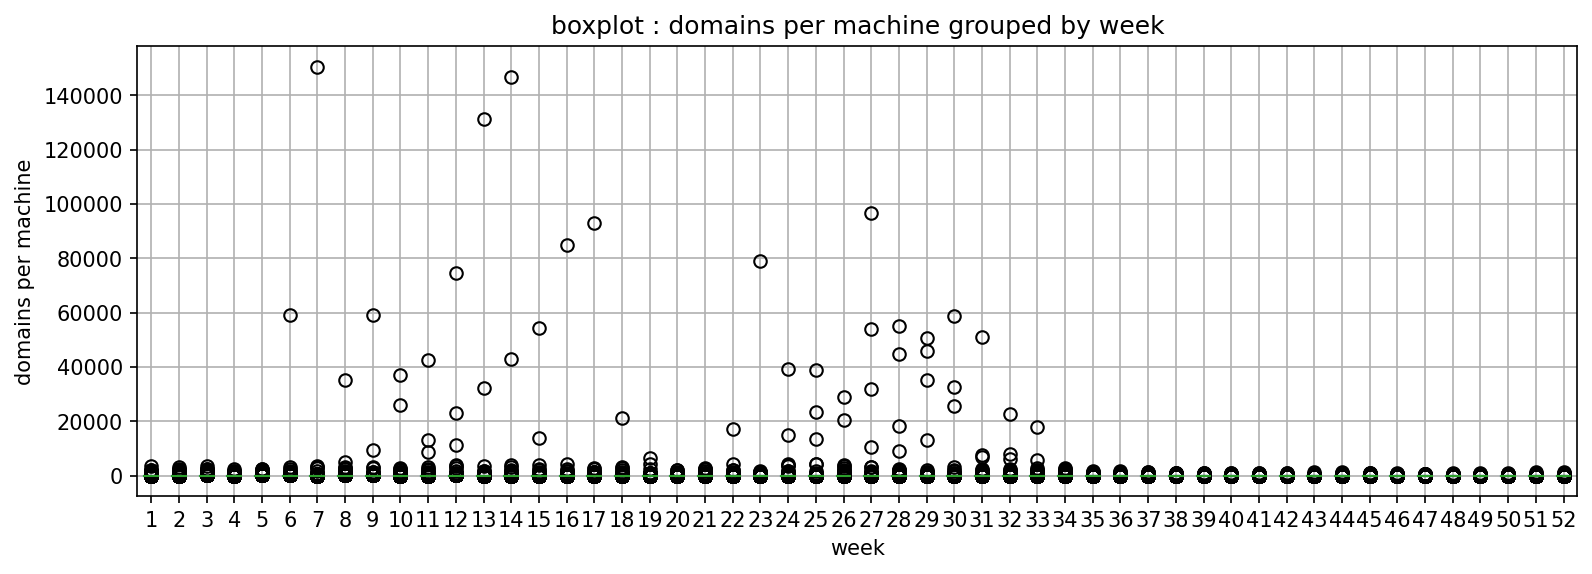

In [8]:
fig, ax = plt.subplots(figsize=(12,4), dpi=150)
weeks_machines_domains_df.boxplot(column=['n_domains'], by='week', ax=ax)
ax.set_ylabel('domains per machine')
fig.suptitle('')
_ = ax.set_title('boxplot : domains per machine grouped by week')

Show plot without extreme outliers.

black dashed line for 7 domains


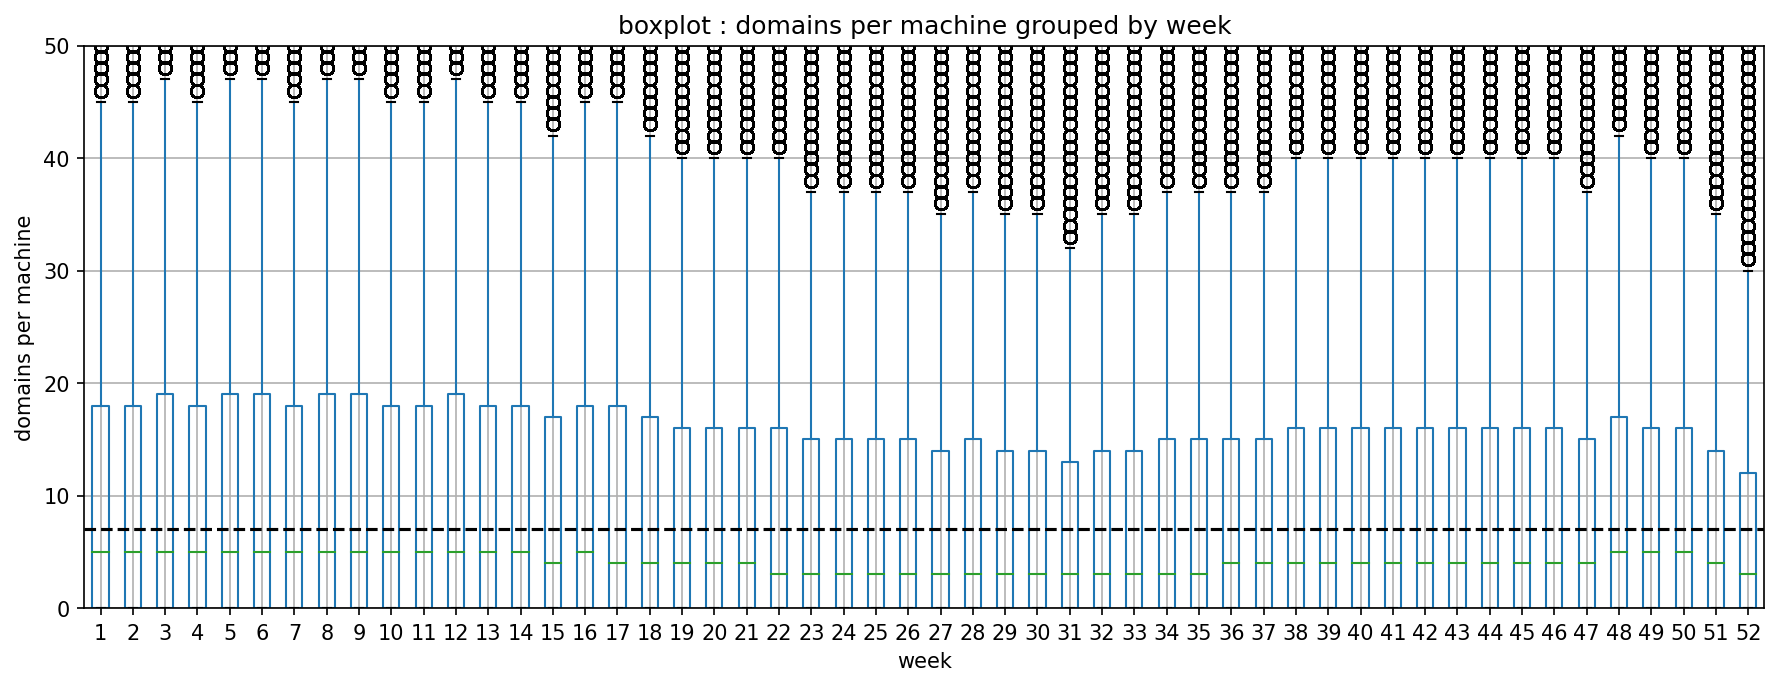

In [9]:
fig, ax = plt.subplots(figsize=(14,5), dpi=150)
weeks_machines_domains_df.boxplot(column=['n_domains'], by='week', ax=ax)
ax.set_ylabel('domains per machine')
fig.suptitle('')
ax.axhline(y=7, linestyle='--', color='black', label='7 domains')
ax.set_ylim(0, 50)
print('black dashed line for 7 domains')
_ = ax.set_title('boxplot : domains per machine grouped by week')

How many machines with at least 7 domains per week?

In [10]:
weeks_machines_domains_df[weeks_machines_domains_df.n_domains >= 7].drop('machine_id',axis=1).head()

,week,n_domains,domains
0,1,119,"{maurices.com, smarttrk.com, pinterest.com, su..."
4,1,8,"{myvoi.org, myway.com, google.com, mshatrainin..."
6,1,45,"{buzzfeed.com, hymnwiki.org, 100layercake.com,..."
7,1,9,"{msn.com, att.net, dresslily.com, obsev.com, a..."
8,1,35,"{gearbest.com, inliberty.ru, golbis.com, admix..."


In [11]:
weeks_machines_7domains = weeks_machines_domains_df[
    (weeks_machines_domains_df.n_domains >= 7)
].groupby('week')['machine_id'].count()
weeks_machines_7domains.head()

week
1    42102
2    42537
3    43892
4    42265
5    44071
Name: machine_id, dtype: int64

In [12]:
weeks_machines_7d_pct = weeks_machines_7domains / weeks_machines_domains_df.machine_id.nunique()
weeks_machines_7d_pct.head()

week
1    0.448882
2    0.453520
3    0.467967
4    0.450620
5    0.469875
Name: machine_id, dtype: float64

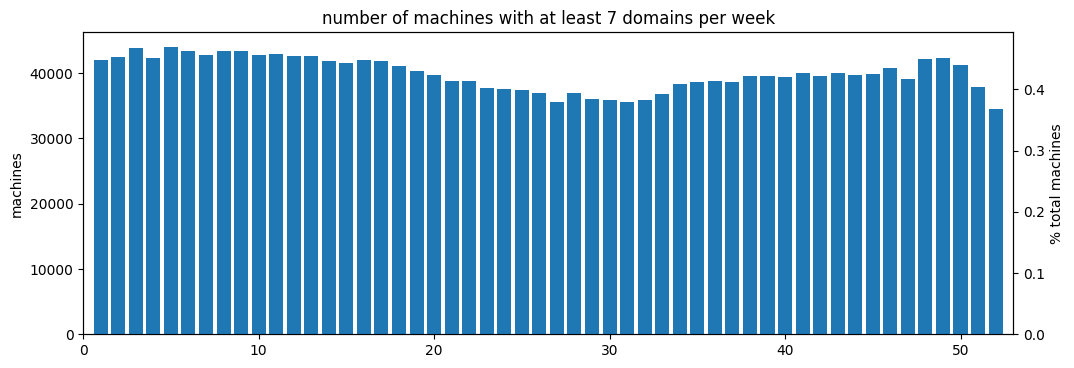

In [13]:
fig, ax = plt.subplots(1,1, figsize=(12, 4), dpi=100)
ax.bar(weeks_machines_7domains.index, weeks_machines_7domains)
ax.set_xlim(0, 53)
ax.set_title('number of machines with at least 7 domains per week')
ax.set_ylabel('machines')
ax_pct = ax.twinx()
ax_pct.bar(weeks_machines_7d_pct.index, weeks_machines_7d_pct)
_ = ax_pct.set_ylabel('% total machines')